In [30]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import Normalizer
from sklearn.cross_validation import cross_val_score
from sklearn.preprocessing import Imputer

from scipy.stats import skew

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use('ggplot')

In [3]:
# read in the data
train = pd.read_csv("C:\\Users\\tyrion\\Documents\\kaggle\housing\\train.csv")
test = pd.read_csv("C:\\Users\\tyrion\\Documents\\kaggle\housing\\test.csv")

## Merge Train and Test to evaluate ranges and missing values
### This was done primarily to ensure that Categorical data in the training and testing data sets were consistent.

In [4]:
# Added 2 features. Moving to next step
# get all features except Id and SalePrice
feature_names = train.columns.difference(['Id','SalePrice'])

# the most hassle free way of working with data is to concatenate them
# since there are many features that contain nan/null values in the test set
# that the train set doesn't
all_data = pd.concat((train.loc[:,feature_names],
                      test.loc[:,feature_names]))

## getting categorical data 

In [5]:
cat_features = all_data.dtypes[all_data.dtypes == "object"].index
cat_feat = all_data[cat_features]
num_feat = all_data.drop(cat_features,axis=1)

### 1) Handle Missing Data for continuous data
     * If any column contains more than 50 entries of missing data, drop the column
     * If any column contains fewer that 50 entries missing , replace those missing values with the median for that column
### 2) Remove outliers using Median Absolute Deviation
### 3) Calculate skewness for each variable and if greater than 0.75 transform it
### 4) Apply the sklearn.Normalizer to each column

In [6]:
def is_outlier(points, thresh = 3.5):
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

In [7]:
for col in num_feat.columns.values:
    #print  np.sum(num_feat[col].isnull())
    if np.sum(num_feat[col].isnull()) > 100:
        print "drop "+col
        num_feat = num_feat.drop(col, axis = 1)  
    elif np.sum(num_feat[col].isnull()) > 0:
        print "median "+col
        median = num_feat[col].median()
        idx = np.where(num_feat[col].isnull())[0]
        num_feat[col].iloc[idx] = median
    
        median = num_feat[col].median()
        outliers = np.where(is_outlier(num_feat[col]))
        #print len(outliers)
        #print outliers
        num_feat[col].iloc[outliers] = median

        if skew(num_feat[col]) > 0.75:
            print "skewed cols "+ col
            num_feat[col] = np.log(num_feat[col])
            num_feat[col] = num_feat[col].apply(lambda x: 0 if x == -np.inf else x)

        num_feat[col] = Normalizer().fit_transform(num_feat[col].reshape(1,-1))[0]

median BsmtFinSF1
skewed cols BsmtFinSF1
median BsmtFinSF2
median BsmtFullBath
median BsmtHalfBath


C:\Users\tyrion\Anaconda2\lib\site-packages\pandas\core\indexing.py:132: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


median BsmtUnfSF
skewed cols BsmtUnfSF
median GarageArea
median GarageCars
drop GarageYrBlt
drop LotFrontage
median MasVnrArea
median TotalBsmtSF


## Handle Missing Data for Categorical Data
    * If any column contains more than 50 entries of missing data, drop the column
    * If any column contains fewer that 50 entries of missing data, replace those values with the 'MIA'
    * Apply the sklearn.LabelEncoder
    * For each categorical variable determine the number of unique values and for each, create a new column that is binary

In [8]:
for col in cat_feat.columns.values:
    if np.sum(cat_feat[col].isnull()) > 50:
        print "drop "+ col
        cat_feat = cat_feat.drop(col, axis = 1)
        continue
    elif np.sum(cat_feat[col].isnull()) > 0:
        print "Fill "+col
        cat_feat[col] = cat_feat[col].fillna('MIA')
        
    cat_feat[col] = LabelEncoder().fit_transform(cat_feat[col])
    
    num_cols = cat_feat[col].max()
    for i in range(num_cols):
        col_name = col + '_' + str(i)
        cat_feat[col_name] = cat_feat[col].apply(lambda x: 1 if x == i else 0)
        
    cat_feat = cat_feat.drop(col, axis = 1)

drop Alley
drop BsmtCond
drop BsmtExposure
drop BsmtFinType1
drop BsmtFinType2
drop BsmtQual
Fill Electrical
Fill Exterior1st
Fill Exterior2nd
drop Fence
drop FireplaceQu
Fill Functional
drop GarageCond
drop GarageFinish
drop GarageQual
drop GarageType
Fill KitchenQual
Fill MSZoning
Fill MasVnrType
drop MiscFeature
drop PoolQC
Fill SaleType
Fill Utilities


## Merging train and test data for modeling

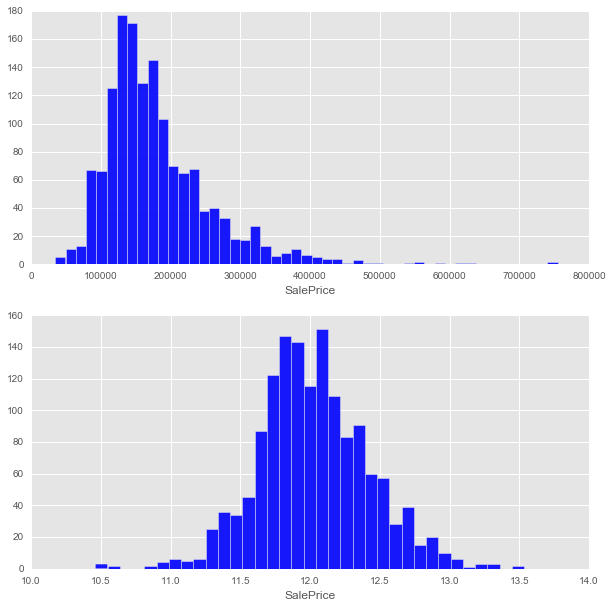

In [9]:
target_log = np.log1p(train['SalePrice'])
plt.figure(1)
fig, ax = plt.subplots(nrows=2)
fig.set_size_inches(10, 10)
sns.distplot(train['SalePrice'], kde = False, color = 'b', hist_kws={'alpha': 0.9},ax=ax[0])
sns.distplot(target_log, kde = False, color = 'b', hist_kws={'alpha': 0.9},ax=ax[1])



In [36]:
final = pd.concat([num_feat,cat_feat],axis=1)
x_train = final.iloc[:len(train)]
y_train = np.log1p(train.SalePrice)
x_test = final.iloc[len(train):]

In [38]:
x_train.loc[:,'All_Liv_SF'] = np.log1p(x_train['1stFlrSF'] + x_train['2ndFlrSF']  + x_train['LowQualFinSF'] + x_train['GrLivArea'])
x_test[:,'All_Liv_SF'] = np.log1p(x_test['1stFlrSF'] + x_test['2ndFlrSF']  + x_test['LowQualFinSF'] + x_test['GrLivArea'])
del x_train['1stFlrSF']
del x_train['2ndFlrSF']
del x_train['LowQualFinSF']
del x_train['GrLivArea']
del x_test['1stFlrSF']
del x_test['2ndFlrSF']
del x_test['LowQualFinSF']
del x_test['GrLivArea']

C:\Users\tyrion\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
C:\Users\tyrion\Anaconda2\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## Create model and do cross validation to check 

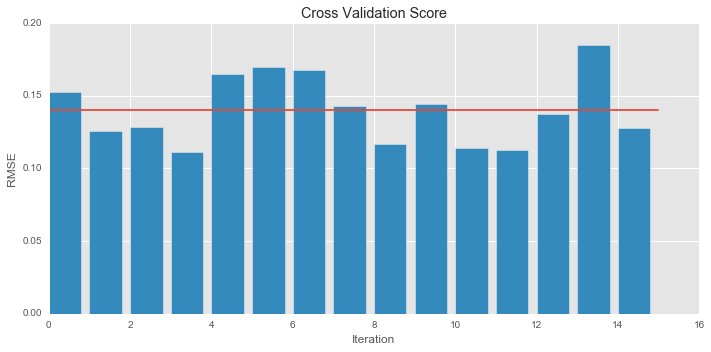

In [39]:
from sklearn.metrics import make_scorer, mean_squared_error
scorer = make_scorer(mean_squared_error, False)

clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)
cv_score = np.sqrt(-cross_val_score(estimator=clf, X=x_train, y=y_train, cv=15, scoring = scorer))

plt.figure(figsize=(10,5))
plt.bar(range(len(cv_score)), cv_score)
plt.title('Cross Validation Score')
plt.ylabel('RMSE')
plt.xlabel('Iteration')

plt.plot(range(len(cv_score) + 1), [cv_score.mean()] * (len(cv_score) + 1))
plt.tight_layout()

In [40]:
print("Mean:",cv_score.mean())
print("Min: ",cv_score.min())

('Mean:', 0.14015671958358977)
('Min: ', 0.1110564673459221)


## Evaluate Feature Significance

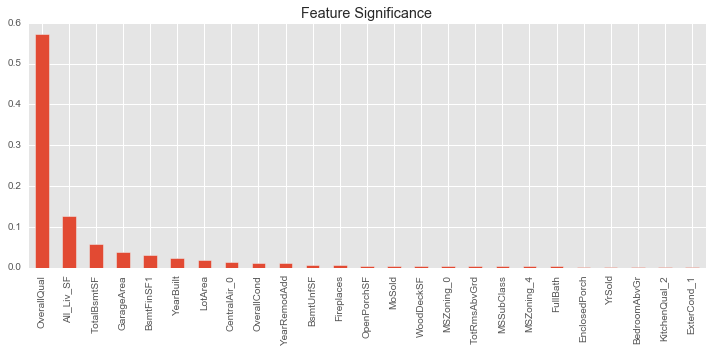

In [41]:
# Fit model with training data
clf.fit(x_train, y_train)

# Output feature importance coefficients, map them to their feature name, and sort values
coef = pd.Series(clf.feature_importances_, index = x_train.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 5))
coef.head(25).plot(kind='bar')
plt.title('Feature Significance')
plt.tight_layout()

## Visualize Predicted vs. Actual Sales Price

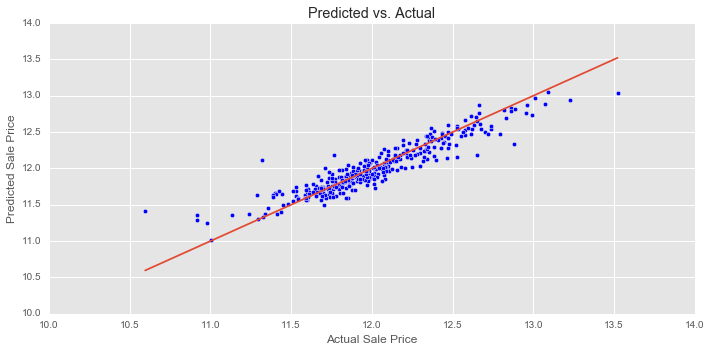

In [42]:
from sklearn.cross_validation import train_test_split

X_train1, X_test1, y_train1, y_test1 = train_test_split(x_train, y_train)
clf = RandomForestRegressor(n_estimators=500, n_jobs=-1)

clf.fit(X_train1, y_train1)
y_pred = clf.predict(X_test1)

plt.figure(figsize=(10, 5))
plt.scatter(y_test1, y_pred, s=20)
plt.title('Predicted vs. Actual')
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')

plt.plot([min(y_test1), max(y_test1)], [min(y_test1), max(y_test1)])
plt.tight_layout()

## Using Lasso Regression

In [43]:
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, x_train, y_train, scoring="neg_mean_squared_error", cv=5))
    return(rmse)

In [44]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV, LinearRegression

0.13608960276071388

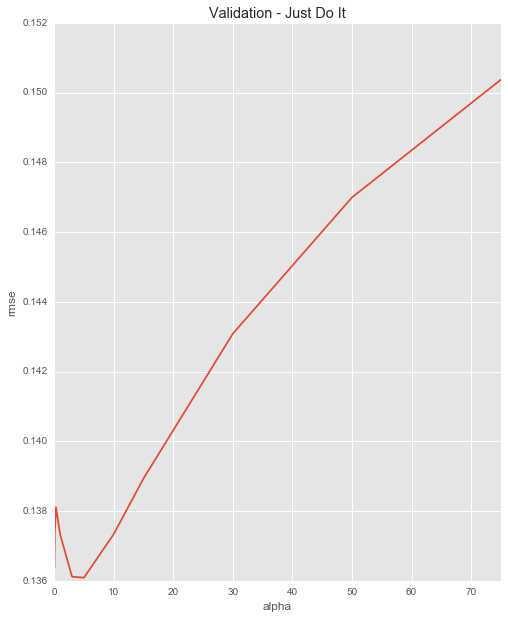

In [64]:
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
cv_ridge.min()

In [65]:
model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], selection='random', max_iter=15000).fit(x_train, y_train)
res = rmse_cv(model_lasso)
print("Mean:",res.mean())
print("Min: ",res.min())

('Mean:', 0.13331197358387098)
('Min: ', 0.11177380889245334)


In [46]:
coef = pd.Series(model_lasso.coef_, index = x_train.columns)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 89 variables and eliminated the other 113 variables


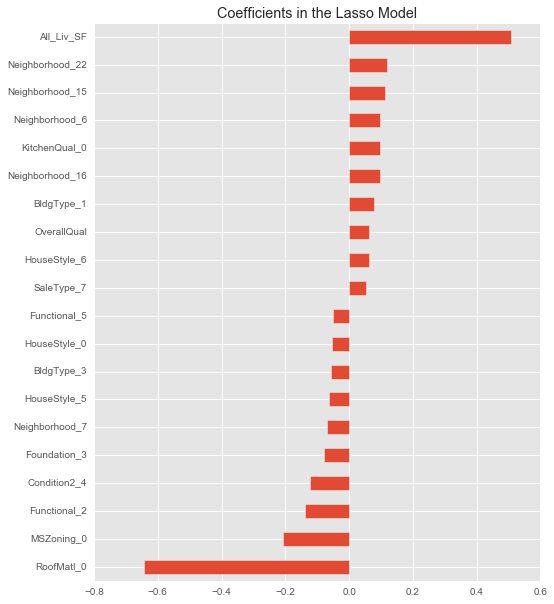

In [47]:
# plotting feature importances!
imp_coef = pd.concat([coef.sort_values().head(10),
                     coef.sort_values().tail(10)])
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Coefficients in the Lasso Model")

In [48]:
# Let's make some predictions and submit it to the lb
test_preds = np.expm1(model_lasso.predict(x_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("lasso_Sushaanth.csv", index=False)

In [49]:
# Let's make some predictions using random forest and submit it to the lb
test_preds = np.expm1(clf.predict(x_test))
submission = pd.DataFrame()
submission['Id'] = test['Id']
submission["SalePrice"] = test_preds
submission.to_csv("random_forest_Sushaanth.csv", index=False)